In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.formula import api as sm
%matplotlib inline

In [4]:
# Read json data on batting stats into a DataFrame.

b_df = pd.read_json('pos_stats.json')

# The DataFrame has 15,133 rows and 13 columns.

b_df.shape

# The columns are ['age', 'avg', 'hr', 'obp', 'ops', 'player_name', 'position', 'rbi', 'salary', 'slg', 'team', 'war', 'year']

b_df.columns

Index(['age', 'avg', 'hr', 'obp', 'ops', 'player_name', 'position', 'rbi',
       'salary', 'slg', 'team', 'war', 'year'],
      dtype='object')

In [5]:
# Salary is object data type.  Need to convert that into an integer value.
# Strip '$', get rid of commas, and convert to integer.

b_df.salary = b_df.salary.apply(lambda x: int(''.join(x.strip('$ ').split(','))) if x else None)

In [6]:
# Some players from the early 20th century got scraped by mistake.
# Get rid of any player-years that are not from 2000 or later.

b_df.drop(b_df[b_df.year < 2000].index, inplace=True)

In [7]:
# 43% of the player-years don't have salary information.
# I will drop those years, though I may want to come back to this later
# and potentially make some assumptions.  E.g. that a salary from a previous
# player-year can be extrapolated forward to another player-year without a salary record.

b_df = b_df.dropna(subset=['salary'])

In [9]:
# Since I am hypothesizing that salary follows a lognormal distribution,
# similar to the distribution of income in the general economy,
# I want to include a log_salary column.

b_df['log_salary'] = np.log(b_df.salary)

In [11]:
# Due to team changes, some team name values need to be fixed.
# E.g. FLA needs to be changed to MIA.

replacements = {
                "FLA": "MIA",
                "MON": "WSN",
                "ANA": "LAA",
                "TBD": "TBR",
                }

b_df = b_df.replace({'team': replacements})

In [12]:
# Next step is to create new columns corresponding to next year's salary and log salary.
# Reset index to prepare for split-apply-combine operation.

b_df = b_df.reset_index(drop=True)

In [13]:
# Group by player, and create next_year_salary column with a shift.

b_df[['next_year_salary', 'next_year_log_salary']] = b_df.groupby('player_name')[['salary', 'log_salary']].apply(lambda x: x.shift(1))

In [15]:
# Drop the resulting null values.

b_df = b_df.dropna(subset=[['next_year_salary', 'next_year_log_salary']])

In [37]:
# There are about 30 rows with missing batting stats.  Drop them.

b_df = b_df.dropna(subset=[['avg', 'obp', 'ops', 'hr', 'rbi', 'slg']])

In [75]:
# Wow...the year tells you 99% of the variance in next_year_log_salary!?
# Maybe need to take delta above league minimum?

model = sm.OLS(b_df.next_year_log_salary, b_df[['year']])
fit = model.fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     next_year_log_salary   R-squared:                       0.991
Model:                              OLS   Adj. R-squared:                  0.991
Method:                   Least Squares   F-statistic:                 6.398e+05
Date:                  Sat, 30 Sep 2017   Prob (F-statistic):               0.00
Time:                          21:45:41   Log-Likelihood:                -9455.5
No. Observations:                  5552   AIC:                         1.891e+04
Df Residuals:                      5551   BIC:                         1.892e+04
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
year           0.0071   8.88e-06    799.874      0.000       0.007       0.007
==============================================================================
Omnibus:                      115.499   Durbin-Watson:                   0.645
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              251.227
Skew:                           0.018   Prob(JB):                     2.80e-55
Kurtosis:                       4.041   Cond. No.                         1.00
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

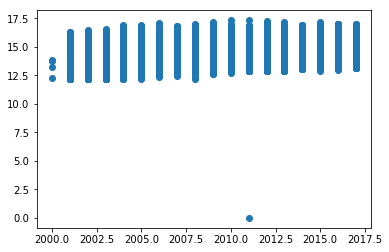

In [78]:
plt.scatter(b_df.year, b_df.next_year_log_salary);
